In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [4]:
predictwise = pd.read_csv('../data/predictwise.csv').set_index('States')

In [5]:
predictwise.head()

,Obama,Romney,Votes
States,,,
Alabama,0.000,1.000,9
Alaska,0.000,1.000,3
Arizona,0.062,0.938,11
Arkansas,0.000,1.000,6
California,1.000,0.000,55


# Simulating a simple election model

## Bernoulli random variables

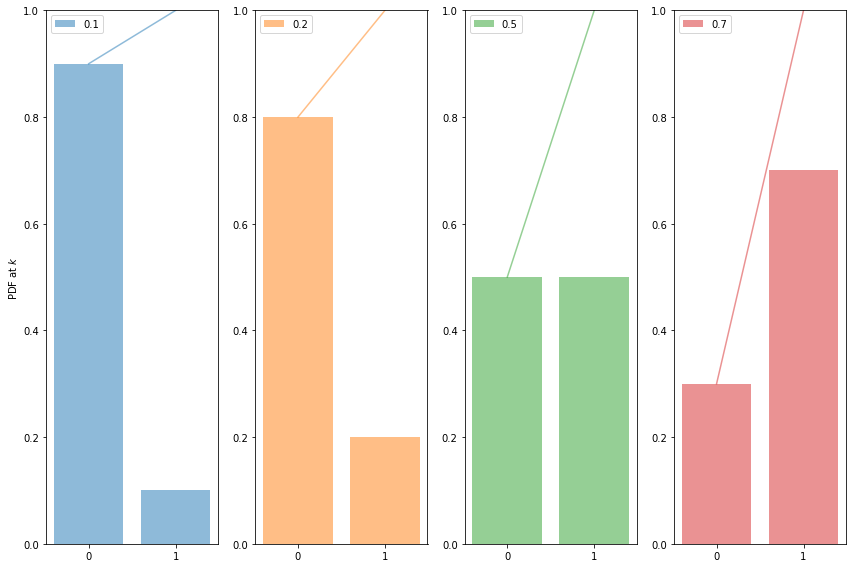

In [8]:
from scipy.stats import bernoulli
import seaborn as sns
event_space=[0,1]
plt.figure(figsize=(12,8))
colors=sns.color_palette()
for i, p in enumerate([0.1, 0.2, 0.5, 0.7]):
    ax = plt.subplot(1, 4, i+1)
    plt.bar(event_space, bernoulli.pmf(event_space, p), label=p, color=colors[i], alpha=0.5)
    plt.plot(event_space, bernoulli.cdf(event_space, p), color=colors[i], alpha=0.5)
    ax.xaxis.set_ticks(event_space)
    plt.ylim((0,1))
    plt.legend(loc=0)
    if i == 0:
        plt.ylabel("PDF at $k$")
plt.tight_layout()

## Running the simulation using Uniform distribution

In [9]:
def simulate_election(model, n_sim):
    simulations = np.random.uniform(size=(51, n_sim))
    obama_votes = (simulations < model.Obama.values.reshape(-1, 1)) * model.Votes.values.reshape(-1, 1)
    #summing over rows gives the total electoral votes for each simulation
    return obama_votes.sum(axis=0)


In [10]:
result = simulate_election(predictwise, 10000)
# number of times Obama won in 10K simulated elections
print((result >= 269).sum())

9962


There are roughly only 50 simulations in which Romney wins the election!

# Displaying the prediction

In [11]:
def plot_simulation(simulation):    
    plt.hist(simulation, bins=np.arange(200, 538, 1), 
             label='simulations', align='left', normed=True)
    plt.axvline(332, 0, .5, color='r', label='Actual Outcome')
    plt.axvline(269, 0, .5, color='k', label='Victory Threshold')
    p05 = np.percentile(simulation, 5.)
    p95 = np.percentile(simulation, 95.)
    iq = int(p95 - p05)
    pwin = ((simulation >= 269).mean() * 100)
    plt.title("Chance of Obama Victory: %0.2f%%, Spread: %d votes" % (pwin, iq))
    plt.legend(frameon=False, loc='upper left')
    plt.xlabel("Obama Electoral College Votes")
    plt.ylabel("Probability")
    sns.despine()

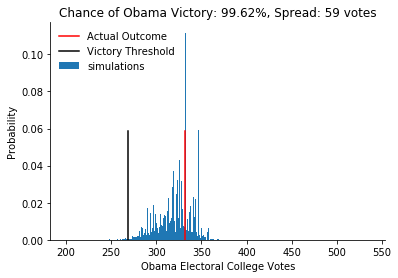

In [14]:
plot_simulation(result)

In [15]:
CDF = lambda x: np.sum(result < x)/result.shape[0]

In [16]:
CDF = lambda x: np.float(np.sum(result < x))/result.shape[0]
for votes in [200, 300, 320, 340, 360, 400, 500]:
    print("Obama Win CDF at votes=", votes, " is ", CDF(votes))


Obama Win CDF at votes= 200  is  0.0
Obama Win CDF at votes= 300  is  0.1505
Obama Win CDF at votes= 320  is  0.449
Obama Win CDF at votes= 340  is  0.8396
Obama Win CDF at votes= 360  is  0.9974
Obama Win CDF at votes= 400  is  1.0
Obama Win CDF at votes= 500  is  1.0


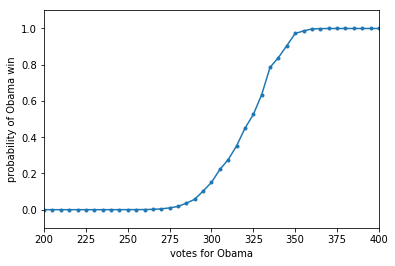

In [18]:
votes=np.arange(0, 540, 5)
plt.plot(votes, [CDF(v) for v in votelist], '.-');
plt.xlim([200,400])
plt.ylim([-0.1,1.1])
plt.xlabel("votes for Obama")
plt.ylabel("probability of Obama win");

# Binomial distribution

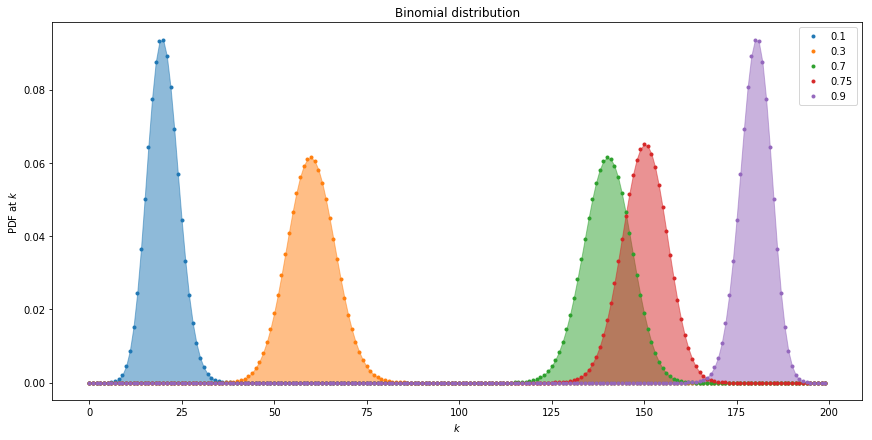

In [19]:
from scipy.stats import binom
plt.figure(figsize=(12,6))
k = np.arange(0, 200)
for p, color in zip([0.1, 0.3, 0.7, 0.75, 0.9], colors):
    rv = binom(200, p)
    plt.plot(k, rv.pmf(k), '.', lw=2, color=color, label=p)
    plt.fill_between(k, rv.pmf(k), color=color, alpha=0.5)
q=plt.legend()
plt.title("Binomial distribution")
plt.tight_layout()
q=plt.ylabel("PDF at $k$")
q=plt.xlabel("$k$")

Using the central limit theorem (CLT), one can approximate the Binomial distribution by Normal distribution. Specifically, as $n  \rightarrow \infty$, we have $S_n = (1/n)\sum_{i}x_i$, where $x_i$ are i.i.d Bernoulli(p) random variable, will follow a normal distribution $N(p, p(1-p)/n)$.

Hence, $nS_n \sim N(np, np(1-p)$

This approximation is used a lot in studying elections. For example, suppose I told you that I’d polled 1000 people in Ohio and found that 600 would vote Democratic, and 400 republican. Imagine that this 1000 is a “sample” drawn from the voting “population” of Ohio. Assume then that these are 1000 independent bernoulli trials with p=600/1000 = 0.6. Then we can say that, from the CLT, the mean of the sampling distribution of the mean of the bernoulli or is 0.6 (equivalently the binomial’s mean is 600), with a variance of 0.6∗0.4/1000=0.00024 (equivalently the binomials variance is 240). Thus the standard deviation is 0.015 for a mean of 0.6, or 1.5% on a mean of 60% voting Democratic. This 1.5% if part of what pollsters quote as the margin of error of a candidates winning; they often include other factors such as errors in polling methodology.

We now build our own predictive model based on Gallup dataset. Gallup measures the political leaning of each state, based on asking random people which party they identify or affiliate with. 

In [44]:
gallup_2012=pd.read_csv('../data/g12.csv').set_index('State')
gallup_2012["Unknown"] = 100 - gallup_2012.Democrat - gallup_2012.Republican
gallup_2012.head()

,Democrat,Republican,Dem_Adv,N,Unknown
State,,,,,
Alabama,36.0,49.6,-13.6,3197,14.4
Alaska,35.9,44.3,-8.4,402,19.8
Arizona,39.8,47.3,-7.5,4325,12.9
Arkansas,41.5,40.8,0.7,2071,17.7
California,48.3,34.6,13.7,16197,17.1


Each row lists a state, the percent of surveyed individuals who identify as Democrat/Republican, the percent whose identification is unknown or who haven’t made an affiliation yet, the margin between Democrats and Republicans (Dem_Adv: the percentage identifying as Democrats minus the percentage identifying as Republicans), and the number N of people surveyed.

Since the poll do not ask everybody. We need to estimate the uncertainty of the pool. THe standard error is calculated as $$SE = \sqrt{\frac{p(1-p)}{N-1}},$$ where p is the ratio of #Democrats/N

In [47]:
gallup_2012["SE_percentage"]=100.0*np.sqrt((gallup_2012.Democrat/100.)*((100. - gallup_2012.Democrat)/100.)/(gallup_2012.N -1))
gallup_2012.head()

,Democrat,Republican,Dem_Adv,N,Unknown,SE_percentage
State,,,,,,
Alabama,36.0,49.6,-13.6,3197,14.4,0.849059
Alaska,35.9,44.3,-8.4,402,19.8,2.395543
Arizona,39.8,47.3,-7.5,4325,12.9,0.744384
Arkansas,41.5,40.8,0.7,2071,17.7,1.082971
California,48.3,34.6,13.7,16197,17.1,0.392658


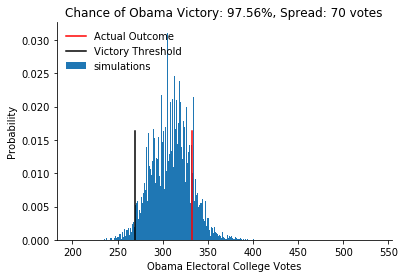

In [49]:
from scipy.special import erf
def uncertain_gallup_model(gallup):
    sigma = 3
    prob =  .5 * (1 + erf(gallup.Dem_Adv / np.sqrt(2 * sigma**2)))
    return pd.DataFrame(dict(Obama=prob), index=gallup.index)
model = uncertain_gallup_model(gallup_2012)
model = model.join(predictwise.Votes)
prediction = simulate_election(model, 10000)
plot_simulation(prediction)

In [50]:
model

,Obama,Votes
State,,
Alabama,2.903004e-06,9
Alaska,2.555130e-03,3
Arizona,6.209665e-03,11
Arkansas,5.922487e-01,6
California,9.999975e-01,55
Colorado,4.151822e-02,9
Connecticut,9.999999e-01,7
Delaware,1.000000e+00,3
District of Columbia,1.000000e+00,3
